In [1]:
#################################### IMPORTS ###################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import datetime
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [2]:
##################### INICIALIZACAO DE VARIAVEIS ################################################
index_arquivo = ['preco', 'hr_int']#, 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'] #index do arquivo
steps = [] # 9h04 -> 17h50 a cada 5 segundos 
epocas = 1000 #quantidade de vezes que vai rodar todos os dias
janela = 10 #janela de valores
n_variaveis = len(index_arquivo) #'preco', 'hr_int', 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'
l = n_variaveis-1
n_mercado = n_variaveis*janela #inputs
n_estados = 2 #ncont e valor
n_neuronios = 216 #numero de neuronios da camada escondida
lim_cont = 5
n_saidas = 2*lim_cont+1   #numero de saidas da rede (compra, vende, segura)
custo = 1.06/2 #custo da operao
melhor_reward = 0

versao_arquivo = 2

carregar_pesos = False
carregar_epoca_epsilon = False
epoca_init = 0
if carregar_epoca_epsilon:
    file = open("./epoca_epsilon.txt", "r")
    valores = file.read().split(',')
    epoca_init = int(valores[0])
    epsilon = float(valores[1])
    file.close()
else:
    epsilon = 1. #valor de epsilon
epsilon_min = 0.01 #valor minimo de epsilon
epsilon_decay = (epsilon - epsilon_min) / (epocas - epoca_init) #o valor que vai retirado do epsilon por epoca

rewards = [0] #variavel para guardar rewards
plotx = [0] #variavel para guardar valores a serem plotados do eixo x

In [3]:
####################### LEITURA DOS DADOS #######################################################
dias = 1

caminho_arquivo = ('./consolidado.csv')
arquivo = pd.read_csv(caminho_arquivo) #le arquivo
inputs = arquivo[index_arquivo]
print(inputs['preco'][0:2])
if versao_arquivo == 1: #se quiser usar apenas os dias com IND e ISP
    inputs = inputs[inputs['IND'] != 0]
    arquivo = arquivo[arquivo['IND'] != 0]

dt = arquivo['dt'].values #cria coluna apenas dos dias

steps = []
ultimo_dia = 0
dias_para_rodar = [] #variavel para colocar os dias a serem rodados
j = 0
hr = []
h = 0

for i in range( 0, len(dt) ):    
    if (dt[i] != ultimo_dia):
        steps.append(i) #numero de linhas entre dias
        ultimo_dia = dt[i]
        dias_para_rodar.append(j) #numero do dia
        j += 1
        h = 0
    hr.append(h)
    h += 1
step_max = np.amax(hr)
batch = step_max + 1

#normalizacao dos dados
hr = hr/step_max
inputs['hr_int'] = hr
pmean = np.mean( inputs.loc[:dias*batch, inputs.columns[0]] ) #define valor minimo do preco  #step = 106
pstd = np.std( inputs.loc[:dias*batch, inputs.columns[0]] ) #define valor maximo do preco
for i in range( inputs.shape[1] ): #roda normalizo para todas as colunas
    imean = np.mean( inputs.loc[:dias*batch, inputs.columns[i]] ) #pega valor maximo
    istd = np.std( inputs.loc[:dias*batch, inputs.columns[i]] ) #pega valor minimo
    
    inputs.loc[:, inputs.columns[i]] = ( inputs.loc[:, inputs.columns[i]] - imean ) / istd #normaliza prs
    
mini_batch_size = int(dias*batch*0.1)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    3907.5
1    3900.0
Name: preco, dtype: float64


D:\anaconda\lib\site-packages\pandas\core\indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [4]:
########################################   BIBLIOTECAS ####################################
import random
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, concatenate
from keras import optimizers
from keras import backend as K            #importa backend para clear_session()


##################### MODELO DQN ####################################################
class DQNAgent:
    ########################### INICIALIZA ###########################################
    def __init__(self, state_size, mkt_size, action_size, epsilon, janela, n_neuronios, n_variaveis):
        self.state_size = state_size
        self.mkt_size = mkt_size
        self.n_neuronios = n_neuronios
        self.action_size = action_size
        self.n_variaveis = n_variaveis
        self.limpa_memoria_dia()
        self.limpa_memoria_epoca()
        self.gamma = 0.97       # discount rate
        self.epsilon = epsilon  # exploration rate
        self.learning_rate = 1e-4
        self.model = self.cria_modelo()
        self.model.summary()
        self.state = []
        self.next_state = []
        self.janela_precos = []
        self.prox_janela_precos = []

################################# REDE NEURAL ###########################################
    def cria_modelo(self):
        # Neural Net for Deep-Q learning Model
        #inputs
        x1 = Input(shape=(self.state_size,))
        x2 = Input(shape=(self.mkt_size,))
        
        #state hidden layers
        a1 = Dense(320, activation='relu')(x1)
        a2 = Dense(256, activation='relu')(a1)
        a3 = Dense(256, activation='relu')(a2)
        
        #mkt hidden layers
        b1 = Dense(320, activation='relu')(x2)
        b2 = Dense(256, activation='relu')(b1)
        b3 = Dense(256, activation='relu')(b2)
        
        #concatenacao
        x12 = concatenate([a3, b3], axis=-1)
        
        #camada de saida
        y = Dense(self.action_size, activation='linear')(x12)
        
        model = Model(inputs=[x1, x2], outputs=y)
        
        sgd = optimizers.SGD(lr=self.learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='mean_squared_error', optimizer=sgd)
        return model

    def limpa_memoria_dia(self):
        self.janela_precos = np.zeros(self.mkt_size)
        self.prox_janela_precos = np.zeros(self.mkt_size)
        self.state = []
        self.next_state = []
    
    def limpa_memoria_epoca(self):
        self.memory = []
        
    def toma_acao(self):
        if np.random.rand() <= self.epsilon: #se o numero aleatorio for menor que o epsilon
            return random.randrange(self.action_size) #retorna acao aleatoria     
        act_values = self.model.predict([self.state, self.janela_precos]) #calcula qual a melhor acao
        return np.argmax(act_values[0])  # returns action
    
    def treina_modelo(self, batch_size=mini_batch_size):
        minibatch = random.sample(self.memory, batch_size)
        
        x1 = np.zeros((batch_size, self.state_size))
        x2 = np.zeros((batch_size, self.mkt_size))
        y = np.zeros((batch_size, self.action_size))
        i = 0
        for acao, reward, estado, mercado, prox_estado, prox_mercado, done in minibatch:        
            
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict([prox_estado, prox_mercado])[0])) #pega valor que quer chegar

            target_f = self.model.predict([estado, mercado]) #pega valor que chegou
            target_f[0][acao+lim_cont] = target #define o valor que deseja chegar
            x1[i,:] = estado
            x2[i,:] = mercado
            y[i,:] = target_f
            i = i + 1
            
        self.model.fit([x1, x2], y, epochs=1, verbose=0) #treina modelo
            
    def remember(self, acao, reward, done):
        self.memory.append((acao, reward, self.state, self.janela_precos, self.next_state, self.prox_janela_precos, done))
    
    def carrega_pesos(self, name):
        self.model.load_weights(name) #carrega pesos

    def salva_pesos(self, name):
        self.model.save_weights(name) #salva pesos
                
########################  DECLARA MODELO ################################
modelo = DQNAgent(n_estados, n_mercado, n_saidas, epsilon, janela, n_neuronios, n_variaveis)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 320)          960         input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 320)          6720        input_2[0][0]                    
____________________________________________________________________________________________

In [5]:
########################### FUNCOES ###############################################################

def atuacao( preco, ncont, acao, custo, valor ):  #preo atual, n de contratos posicionados,
                                                #acaoo atual, custo, valor da posio
    preco_cheio = 0.
    valor_cheio = 0.
    ncont_anterior = ncont #salva posio anterior
    ncont = acao #posicao atual = acao
    reward = 0.
    posicao = 0.
    dp = 0.

    
    #variaveis para tratamento do sinal de ncont, ncont_anterior e da acao
    acao = ncont - ncont_anterior  #ajuda a manter as condições anteriores
    var1 = ncont*ncont_anterior
    var2 = ncont*acao

    if acao != 0:
        #realizacao de lucros e custos
        if ((var2>0) and (var1>=0)):
            #aumento da posicao
            reward = -custo*abs(acao)    #reward = -custo*acao se houve operacao (aumento da posicao)
            #aumento da posicao = preco medio:
            valor = (ncont_anterior*valor + acao*preco)/ncont  
            
        else:
            valor_cheio = valor * pstd + pmean  #valores nao normalizados
            preco_cheio = preco * pstd + pmean
            if (var1)>= 0:
                #diminuicao da posicao
                reward = acao*(valor_cheio - preco_cheio)*10 - custo*abs(acao)  #reward se houve diminuicao da posicao
                #valor medio nao muda na diminuicao, somente se ncont==0:
                if ncont==0: valor=-10
                    
            else:
                #troca de posicao
                reward = (-ncont_anterior)*(valor_cheio - preco_cheio)*10 - custo*abs(acao)  #reward se houve troca da posicao
                #preco medio da posicao = preco da troca de posicao
                valor = preco
    
    #definindo o lucro potencial da carteira(posicao)
    if valor!=-10:
        valor_cheio = valor * pstd + pmean  #valor posicionado atual      
        dp = (preco * pstd + pmean) - valor_cheio #variacao do preco atual e do preco de compra/venda
        posicao = ncont * dp * 10 - custo*abs(ncont)           #posicao = lucro (POTENCIAL)
        
    return ncont, valor, posicao, reward

def obter_acao(ncont):
    decisao = modelo.toma_acao() #calcula a saida da rede neural
    return (decisao - lim_cont)

def rodar_1dia(precos, custo, dia):
    global melhor_reward
    ncont = 0 #cria variavel de quantidade de contratos
    ncont_anterior = 0 #cria variavel para quantidade de contratos anterior
    valor = -10 #cria variavel para preo medio
    reward = 0. #cria variavel para recompensa
    lucro = 0.
    posicao = 0 #cria variavel de posio 
    erro = []
    modelo.limpa_memoria_dia() #limpa o vetor de memoria
    done = False
    posicao_max = 1e4
    shp = modelo.janela_precos.shape
    
    for step in range( steps[dia], steps[dia+1] ):  #roda os dados
        
        ultimos_precos = precos[ step : step + 1 ] #pega os valores de agora
        modelo.janela_precos = np.reshape(np.delete(np.insert(modelo.janela_precos,shp,np.concatenate(ultimos_precos.values).tolist()),[0,l]), (1,modelo.mkt_size))
        modelo.state = np.reshape([ncont/lim_cont, valor], (1,modelo.state_size)) #adiciona na variavel de estado      
        
        acao = obter_acao(ncont)        
        ncont, valor, posicao, reward = atuacao(precos['preco'][step], ncont, acao, custo, valor)
        
        #pos acao
        lucro += reward    #LUCRO ACUMULADO
        
        #v=valor if valor==-10 else valor*pstd+pmean
        #p=precos['preco'][step]*pstd+pmean
        #print("acao={0}; ncont={1}; valor={2}; preco={3}; posicao={4}; lucro={5}; reward={6}".format(acao, ncont, v, p, posicao, lucro, reward))   

        if step == (steps[dia] - 1): #se ultimo step do dia
            done = True     
            prox_precos = np.zeros(n_variaveis)
            modelo.prox_janela_precos = np.reshape(np.delete(np.insert(modelo.prox_janela_precos,shp,prox_precos),[0,l]),(1,modelo.mkt_size))
        else:
            prox_precos = precos[ step + 1 : step + 2 ] #pega os proximos valores
            modelo.prox_janela_precos = np.reshape(np.delete(np.insert(modelo.prox_janela_precos,shp,np.concatenate(prox_precos.values).tolist()),[0,l]),(1,modelo.mkt_size))
        
        modelo.next_state = np.reshape([ncont/lim_cont, valor], (1,modelo.state_size)) #adiciona na variavel de estado      
        modelo.remember(acao, posicao/posicao_max, done)  #salva step na memoria - reward = lucro instantaneo que a ação gerou
        
    #fim do dia
    lucro += posicao

    #print("ncont zerados={0}; posicao={1}".format(ncont, posicao))
    if lucro > melhor_reward:
        melhor_reward = lucro
    return lucro #retorna o valor do reward

dias_pos = 0
dias_neg = 0

def rodar_dias(precos, custo):   
    global dias_pos
    global dias_neg
    sum_rewards = 0 #cria variavel de somatoria de recompensas
    
    for dia in range( 0, dias ): #loop de dias
        reward = rodar_1dia(precos, custo, dia)
        sum_rewards += reward #roda 1 dia e adiciona o total na variavel de somatoria
        
        if reward>0: 
            dias_pos += 1
        elif reward<0:
            dias_neg += 1
    return sum_rewards


W1107 22:19:03.568048  2468 deprecation_wrapper.py:119] From D:\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



resultado da epoca 0 = -1474.42 Epsilon = 1.000
0
1
resultado da epoca 1 = 336.32 Epsilon = 0.999
1
0
resultado da epoca 2 = -261.54 Epsilon = 0.998
0
1
resultado da epoca 3 = 526.64 Epsilon = 0.997
1
0
resultado da epoca 4 = 662.84 Epsilon = 0.996
1
0
resultado da epoca 5 = -18.06 Epsilon = 0.995
0
1
resultado da epoca 6 = -637.62 Epsilon = 0.994
0
1
resultado da epoca 7 = -189.12 Epsilon = 0.993
0
1
resultado da epoca 8 = 593.30 Epsilon = 0.992
1
0
resultado da epoca 9 = 241.02 Epsilon = 0.991
1
0
resultado da epoca 10 = 82.70 Epsilon = 0.990
1
0
resultado da epoca 11 = -1598.98 Epsilon = 0.989
0
1
resultado da epoca 12 = -951.86 Epsilon = 0.988
0
1
resultado da epoca 13 = -1994.44 Epsilon = 0.987
0
1
resultado da epoca 14 = 349.66 Epsilon = 0.986
1
0
resultado da epoca 15 = 588.44 Epsilon = 0.985
1
0
resultado da epoca 16 = -115.64 Epsilon = 0.984
0
1
resultado da epoca 17 = -849.74 Epsilon = 0.983
0
1
resultado da epoca 18 = -1766.40 Epsilon = 0.982
0
1
resultado da epoca 19 = -114

resultado da epoca 159 = -1548.22 Epsilon = 0.843
0
1
resultado da epoca 160 = -1310.34 Epsilon = 0.842
0
1
resultado da epoca 161 = 938.28 Epsilon = 0.841
1
0
resultado da epoca 162 = -1920.50 Epsilon = 0.840
0
1
resultado da epoca 163 = -864.28 Epsilon = 0.839
0
1
resultado da epoca 164 = -1030.18 Epsilon = 0.838
0
1
resultado da epoca 165 = -1436.40 Epsilon = 0.837
0
1
resultado da epoca 166 = -177.30 Epsilon = 0.836
0
1
resultado da epoca 167 = 470.26 Epsilon = 0.835
1
0
resultado da epoca 168 = -922.62 Epsilon = 0.834
0
1
resultado da epoca 169 = -280.18 Epsilon = 0.833
0
1
resultado da epoca 170 = -190.64 Epsilon = 0.832
0
1
resultado da epoca 171 = 121.78 Epsilon = 0.831
1
0
resultado da epoca 172 = 1337.24 Epsilon = 0.830
1
0
resultado da epoca 173 = -32.30 Epsilon = 0.829
0
1
resultado da epoca 174 = -2106.10 Epsilon = 0.828
0
1
resultado da epoca 175 = 1267.54 Epsilon = 0.827
1
0
resultado da epoca 176 = -150.34 Epsilon = 0.826
0
1
resultado da epoca 177 = -565.04 Epsilon = 0

resultado da epoca 315 = -1836.88 Epsilon = 0.688
0
1
resultado da epoca 316 = 1731.32 Epsilon = 0.687
1
0
resultado da epoca 317 = 44.06 Epsilon = 0.686
1
0
resultado da epoca 318 = 101.78 Epsilon = 0.685
1
0
resultado da epoca 319 = -2119.30 Epsilon = 0.684
0
1
resultado da epoca 320 = 13.74 Epsilon = 0.683
1
0
resultado da epoca 321 = -311.40 Epsilon = 0.682
0
1
resultado da epoca 322 = 941.92 Epsilon = 0.681
1
0
resultado da epoca 323 = -569.44 Epsilon = 0.680
0
1
resultado da epoca 324 = -1156.40 Epsilon = 0.679
0
1
resultado da epoca 325 = -1178.68 Epsilon = 0.678
0
1
resultado da epoca 326 = 5.10 Epsilon = 0.677
1
0
resultado da epoca 327 = 164.34 Epsilon = 0.676
1
0
resultado da epoca 328 = -117.92 Epsilon = 0.675
0
1
resultado da epoca 329 = 75.86 Epsilon = 0.674
1
0
resultado da epoca 330 = -994.30 Epsilon = 0.673
0
1
resultado da epoca 331 = 313.58 Epsilon = 0.672
1
0
resultado da epoca 332 = -2563.38 Epsilon = 0.671
0
1
resultado da epoca 333 = -1103.98 Epsilon = 0.670
0
1


resultado da epoca 472 = -103.10 Epsilon = 0.533
0
1
resultado da epoca 473 = -1063.40 Epsilon = 0.532
0
1
resultado da epoca 474 = 966.46 Epsilon = 0.531
1
0
resultado da epoca 475 = 398.58 Epsilon = 0.530
1
0
resultado da epoca 476 = -421.44 Epsilon = 0.529
0
1
resultado da epoca 477 = -376.26 Epsilon = 0.528
0
1
resultado da epoca 478 = 934.04 Epsilon = 0.527
1
0
resultado da epoca 479 = -486.42 Epsilon = 0.526
0
1
resultado da epoca 480 = -1762.78 Epsilon = 0.525
0
1
resultado da epoca 481 = 232.98 Epsilon = 0.524
1
0
resultado da epoca 482 = 695.54 Epsilon = 0.523
1
0
resultado da epoca 483 = -258.68 Epsilon = 0.522
0
1
resultado da epoca 484 = 342.34 Epsilon = 0.521
1
0
resultado da epoca 485 = 2117.98 Epsilon = 0.520
1
0
resultado da epoca 486 = 537.68 Epsilon = 0.519
1
0
resultado da epoca 487 = 219.18 Epsilon = 0.518
1
0
resultado da epoca 488 = -1016.12 Epsilon = 0.517
0
1
resultado da epoca 489 = -1034.76 Epsilon = 0.516
0
1
resultado da epoca 490 = -748.84 Epsilon = 0.515
0

resultado da epoca 629 = 197.66 Epsilon = 0.377
1
0
resultado da epoca 630 = 51.74 Epsilon = 0.376
1
0
resultado da epoca 631 = -626.44 Epsilon = 0.375
0
1
resultado da epoca 632 = -864.78 Epsilon = 0.374
0
1
resultado da epoca 633 = -320.24 Epsilon = 0.373
0
1
resultado da epoca 634 = -1900.68 Epsilon = 0.372
0
1
resultado da epoca 635 = -728.26 Epsilon = 0.371
0
1
resultado da epoca 636 = -1074.02 Epsilon = 0.370
0
1
resultado da epoca 637 = -1375.38 Epsilon = 0.369
0
1
resultado da epoca 638 = -700.82 Epsilon = 0.368
0
1
resultado da epoca 639 = -265.98 Epsilon = 0.367
0
1
resultado da epoca 640 = -1467.50 Epsilon = 0.366
0
1
resultado da epoca 641 = 732.66 Epsilon = 0.365
1
0
resultado da epoca 642 = -636.74 Epsilon = 0.364
0
1
resultado da epoca 643 = -509.46 Epsilon = 0.363
0
1
resultado da epoca 644 = -133.40 Epsilon = 0.362
0
1
resultado da epoca 645 = -620.24 Epsilon = 0.361
0
1
resultado da epoca 646 = 110.82 Epsilon = 0.360
1
0
resultado da epoca 647 = -634.02 Epsilon = 0.35

resultado da epoca 785 = -1145.72 Epsilon = 0.223
0
1
resultado da epoca 786 = -362.22 Epsilon = 0.222
0
1
resultado da epoca 787 = -206.92 Epsilon = 0.221
0
1
resultado da epoca 788 = -181.30 Epsilon = 0.220
0
1
resultado da epoca 789 = -14.18 Epsilon = 0.219
0
1
resultado da epoca 790 = -140.26 Epsilon = 0.218
0
1
resultado da epoca 791 = -368.58 Epsilon = 0.217
0
1
resultado da epoca 792 = 367.80 Epsilon = 0.216
1
0
resultado da epoca 793 = -884.50 Epsilon = 0.215
0
1
resultado da epoca 794 = -391.46 Epsilon = 0.214
0
1
resultado da epoca 795 = 55.66 Epsilon = 0.213
1
0
resultado da epoca 796 = -376.48 Epsilon = 0.212
0
1
resultado da epoca 797 = 411.42 Epsilon = 0.211
1
0
resultado da epoca 798 = -934.20 Epsilon = 0.210
0
1
resultado da epoca 799 = -262.66 Epsilon = 0.209
0
1
resultado da epoca 800 = -639.04 Epsilon = 0.208
0
1
resultado da epoca 801 = -364.18 Epsilon = 0.207
0
1
resultado da epoca 802 = -202.22 Epsilon = 0.206
0
1
resultado da epoca 803 = -435.10 Epsilon = 0.205
0

resultado da epoca 942 = -232.54 Epsilon = 0.067
0
1
resultado da epoca 943 = -312.24 Epsilon = 0.066
0
1
resultado da epoca 944 = -102.70 Epsilon = 0.065
0
1
resultado da epoca 945 = -636.02 Epsilon = 0.064
0
1
resultado da epoca 946 = -456.32 Epsilon = 0.063
0
1
resultado da epoca 947 = -862.24 Epsilon = 0.062
0
1
resultado da epoca 948 = -711.18 Epsilon = 0.061
0
1
resultado da epoca 949 = -763.60 Epsilon = 0.060
0
1
resultado da epoca 950 = -831.62 Epsilon = 0.059
0
1
resultado da epoca 951 = -790.72 Epsilon = 0.059
0
1
resultado da epoca 952 = -499.06 Epsilon = 0.058
0
1
resultado da epoca 953 = -1065.42 Epsilon = 0.057
0
1
resultado da epoca 954 = -735.12 Epsilon = 0.056
0
1
resultado da epoca 955 = 491.40 Epsilon = 0.055
1
0
resultado da epoca 956 = -781.48 Epsilon = 0.054
0
1
resultado da epoca 957 = -430.42 Epsilon = 0.053
0
1
resultado da epoca 958 = -439.06 Epsilon = 0.052
0
1
resultado da epoca 959 = -653.30 Epsilon = 0.051
0
1
resultado da epoca 960 = -373.00 Epsilon = 0.0

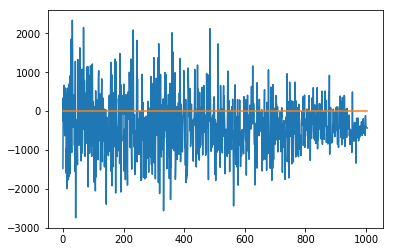

In [6]:
import time
##################################  MAIN  #########################################
if __name__ == "__main__":
    global dias_pos
    global dias_neg
    sr=[]
    try:
        if carregar_pesos:
            modelo.carrega_pesos('./pesos.h5')
        epoca_parou = epoca_init
        for epoca in range(epoca_init, epocas+5): #rodar uma quantidade de epocas
            modelo.limpa_memoria_epoca()
            sum_rewards = rodar_dias(inputs, custo) #adiciona o resultado da epoca na somatoria
            modelo.treina_modelo() #roda o modelo com toda a memoria da epoca
            sr.append(sum_rewards)
            print("resultado da epoca {0} = {1:0.2f} Epsilon = {2:0.3f}".format(epoca, sum_rewards, modelo.epsilon))
            print(dias_pos)
            print(dias_neg)
            epoca_parou += 1
            if ((epoca % 200) == 0):
                modelo.salva_pesos('./pesos_5.h5')
            dias_pos = 0
            dias_neg = 0            
            if modelo.epsilon <= epsilon_min:
                modelo.epsilon = epsilon_min
            else:
                modelo.epsilon -= epsilon_decay
    finally:
        modelo.salva_pesos('./pesos2.h5')
        if carregar_epoca_epsilon:
            file = open("./epoca_epsilon.txt", "w")
            file.writelines("{0},{1}".format(epoca_parou, modelo.epsilon))
            file.close()
            print("parou na epoca {0} com epsilon {1}".format(epoca_parou, modelo.epsilon))
            
        print("Melhor resultado diario: {0:0.2f}".format(melhor_reward))
        plt.plot(range(0, len(sr)), sr, range(0, len(sr)), np.zeros(len(sr))) #plota os valores de reward por epoca

0